In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nengo
import ssp_bayes_opt
from scipy.special import softmax

A normal SSP:

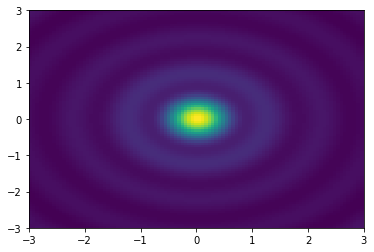

In [2]:
n_scales=6
n_rotates=5
bounds = 3*np.array([[-1,1],[-1,1]])
ssp_space = ssp_bayes_opt.sspspace.HexagonalSSPSpace(2,
                                    ssp_dim=151, 
                                    n_rotates=5, 
                                    n_scales=n_scales, 
                                    scale_min=0.05,
                                    scale_max=3,
                                    domain_bounds=bounds, 
                                    length_scale=0.5,
                                      )
S0 = ssp_space.encode(np.array([[0,0]]))  
ssp_space.similarity_plot(S0)

SSPs representing two regions:

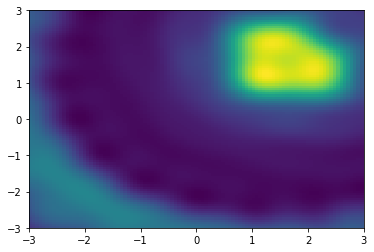

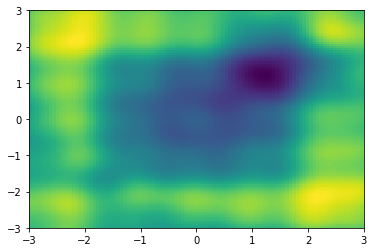

In [3]:
xs = np.linspace(bounds[0,0],bounds[0,1],10)
ys = np.linspace(bounds[1,0],bounds[1,1],10)
X,Y = np.meshgrid(xs,ys)
xy = np.vstack([X.reshape(-1),Y.reshape(-1)]).T


dists = np.sqrt(np.sum((xy - np.array([1.5,1.5]))**2, axis=1))
r1_pts = xy[dists>1,:]
r2_pts = xy[dists<=1,:]
S_r1 = ssp_space.normalize(np.sum(ssp_space.encode(r1_pts),axis=0))
S_r2 = ssp_space.normalize(np.sum(ssp_space.encode(r2_pts),axis=0))
S_regions = np.vstack([S_r1,S_r2])


ssp_space.similarity_plot(S_r2)
ssp_space.similarity_plot(S_r1)


Using masks in the fourier domain to change the length scale:

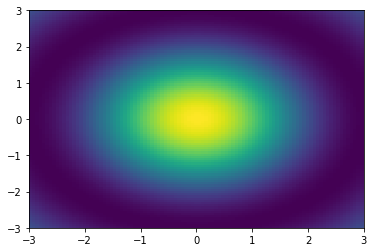

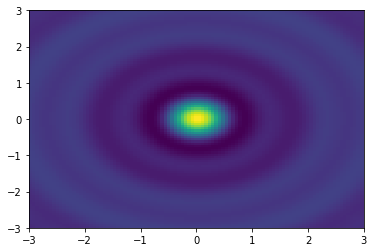

In [4]:
break_idx=4
scale_mask = np.ones((n_scales,2))
scale_mask[:break_idx,0] = 0
scale_mask[break_idx:,1] = 0

mask_half = np.tile(np.repeat(scale_mask,3,axis=0),(n_rotates,1))
masks = np.vstack([[1,1],mask_half, np.flip(mask_half,axis=0)]).T


ssp_space.similarity_plot( np.fft.ifft(np.fft.fft(S0)*masks[0,:]).real )
ssp_space.similarity_plot( np.fft.ifft(np.fft.fft(S0)*masks[1,:]).real )

Encoding an SSP in such a way that the length scale changes depending on its membership in different regions:

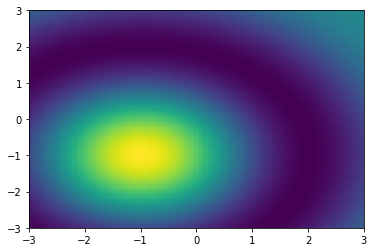

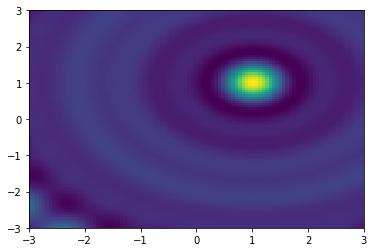

In [5]:
def region_mask_ssp(ssp):
    fssp = np.fft.fft(ssp,axis=1)
    # weights = softmax(S_regions @ ssp.T)
    probs = softmax(S_regions @ ssp.T)
    maxprobs = np.argmax(probs,axis=0)
    weights = np.zeros((S_regions.shape[0],ssp.shape[0])) 
    weights[(maxprobs,np.arange(ssp.shape[0]))] = 1
    weighted_masks =  weights.T @ masks
    #np.sum(weights * masks, axis=0)
    return np.fft.ifft(weighted_masks*fssp,axis=1).real

S_ex = ssp_space.encode(np.array([[-1,-1]]))  
ssp_space.similarity_plot(region_mask_ssp(S_ex))

S_ex = ssp_space.encode(np.array([[1,1]]))  
ssp_space.similarity_plot(region_mask_ssp(S_ex))

Above we have the similarity of the modified SSP with normal SSPs gridded across space. 

Instead, all SSPs (including in grid) can be modifed:

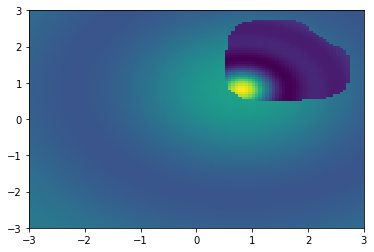

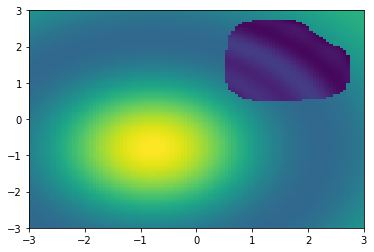

In [6]:
def similarity_plot_v2(ssp_space,ssp,n_grid=100,plot_type='heatmap',ax=None,**kwargs):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    xs = np.linspace(ssp_space.domain_bounds[0,0],ssp_space.domain_bounds[0,1], n_grid)
    ys = np.linspace(ssp_space.domain_bounds[1,0],ssp_space.domain_bounds[1,1], n_grid)
    X,Y = np.meshgrid(xs,ys)
    sims = ssp @ region_mask_ssp(ssp_space.encode(np.vstack([X.reshape(-1),Y.reshape(-1)]).T)).T
    if plot_type=='heatmap':
        im = ax.pcolormesh(X,Y,sims.reshape(X.shape),**kwargs)
    elif plot_type=='contour':
        im = ax.contour(X,Y,sims.reshape(X.shape),**kwargs)
    elif plot_type=='contourf':
        im = ax.contourf(X,Y,sims.reshape(X.shape),**kwargs)
    ax.set_xlim(ssp_space.domain_bounds[0,0],ssp_space.domain_bounds[0,1])
    ax.set_ylim(ssp_space.domain_bounds[1,0],ssp_space.domain_bounds[1,1])
    return im

S_ex = ssp_space.encode(np.array([[0.8,0.8]]))  
similarity_plot_v2(ssp_space,S_ex)

S_ex = ssp_space.encode(np.array([[-0.8,-0.8]]))  
similarity_plot_v2(ssp_space,S_ex)

100.0


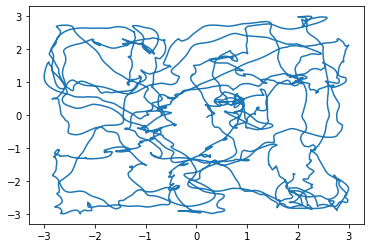

In [7]:
import scipy.io
dat = scipy.io.loadmat('11084-03020501_t2c1.mat')

path = np.hstack([dat['x1'], dat['y1']])/5
path = path[np.all(np.isfinite(path),axis=1),:]
path = path[:10000,:]

shift_fun = lambda x, new_min, new_max: (new_max - new_min)*(x - np.min(x))/(np.max(x) - np.min(x))  + new_min
path[:,0] = shift_fun(path[:,0], -3,3)
path[:,1] = shift_fun(path[:,1], -3,3)

dt = 0.01
timesteps = np.arange(0,dt*path.shape[0] + dt,dt)
T = timesteps[-1]

plt.figure()
plt.plot(path[:,0],path[:,1])
print(T)

In [8]:
def sample_grid_encoders(ssp_space, n):
    sample_pts = ssp_space.get_sample_points(n,method='sobol')
    n = sample_pts.shape[0]
    N = ssp_space.num_grids
    if N < n:
        sorts = np.hstack([np.arange(N), np.random.randint(0, N - 1, size = n - N)])
    else:
        sorts = np.arange(n)
    encoders = np.zeros((n,ssp_space.ssp_dim))
    for i in range(n):
        sub_mat = _get_sub_SSP(sorts[i],N,sublen=ssp_space.grid_basis_dim)
        #print(sub_mat.shape)
        proj_mat = _proj_sub_SSP(sorts[i],N,sublen=ssp_space.grid_basis_dim)
        sub_space = ssp_bayes_opt.sspspace.SSPSpace(ssp_space.domain_dim,2*ssp_space.grid_basis_dim + 1, 
                             axis_matrix= sub_mat @ ssp_space.axis_matrix)
        encoders[i,:] = N * proj_mat @ sub_space.encode(np.atleast_2d(sample_pts[i,:])).reshape(-1)
    return encoders, sorts

def _get_sub_FourierSSP(n, N, sublen=3):
    # Return a matrix, \bar{A}_n
    # Consider the multi scale representation (S_{total}) and sub vectors (S_n) described in the paper 
    # Then
    # \bar{A}_n F{S_{total}} = F{S_n}
    # i.e. pick out the sub vector in the Fourier domain
    tot_len = 2*sublen*N + 1
    FA = np.zeros((2*sublen + 1, tot_len))
    FA[0:sublen, sublen*n:sublen*(n+1)] = np.eye(sublen)
    FA[sublen, sublen*N] = 1
    FA[sublen+1:, tot_len - np.arange(sublen*(n+1),sublen*n,-1)] = np.eye(sublen)
    return FA

def _get_sub_SSP(n,N,sublen=3):
    # Return a matrix, A_n
    # Consider the multi scale representation (S_{total}) and sub vectors (S_n) described in the paper 
    # Then
    # A_n S_{total} = S_n
    # i.e. pick out the sub vector in the time domain
    tot_len = 2*sublen*N + 1
    FA = _get_sub_FourierSSP(n,N,sublen=sublen)
    W = np.fft.fft(np.eye(tot_len))
    invW = np.fft.ifft(np.eye(2*sublen + 1))
    A = invW @ np.fft.ifftshift(FA) @ W
    return A.real

def _proj_sub_FourierSSP(n,N,sublen=3):
    # Return a matrix, \bar{B}_n
    # Consider the multi scale representation (S_{total}) and sub vectors (S_n) described in the paper 
    # Then
    # \sum_n \bar{B}_n F{S_{n}} = F{S_{total}}
    # i.e. project the sub vector in the Fourier domain such that summing all such projections gives the full vector in Fourier domain
    tot_len = 2*sublen*N + 1
    FB = np.zeros((2*sublen + 1, tot_len))
    FB[0:sublen, sublen*n:sublen*(n+1)] = np.eye(sublen)
    FB[sublen, sublen*N] = 1/N # all sub vectors have a "1" zero freq term so scale it so full vector will have 1 
    FB[sublen+1:, tot_len - np.arange(sublen*(n+1),sublen*n,-1)] = np.eye(sublen)
    return FB.T

def _proj_sub_SSP(n,N,sublen=3):
    # Return a matrix, B_n
    # Consider the multi scale representation (S_{total}) and sub vectors (S_n) described in the paper 
    # Then
    # \sum_n B_n S_{n} = S_{total}
    # i.e. project the sub vector in the time domain such that summing all such projections gives the full vector
    tot_len = 2*sublen*N + 1
    FB = _proj_sub_FourierSSP(n,N,sublen=sublen)
    invW = np.fft.ifft(np.eye(tot_len))
    W = np.fft.fft(np.eye(2*sublen + 1))
    B = invW @ np.fft.ifftshift(FB) @ W
    return B.real

/home/ns2dumon/anaconda3/lib/python3.7/site-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


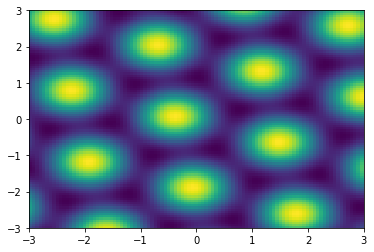

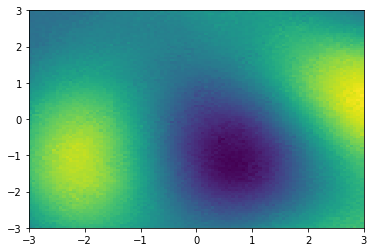

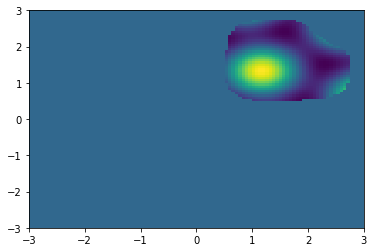

In [9]:
G_encoders, G_sorts = sample_grid_encoders(ssp_space, 10)

ssp_space.similarity_plot(G_encoders[9,:])
ssp_space.similarity_plot(region_mask_ssp(G_encoders[9,:].reshape(1,-1)))
similarity_plot_v2(ssp_space,G_encoders[9,:])

In [10]:
d = ssp_space.ssp_dim
n_neurons = 2000
G_encoders, G_sorts = sample_grid_encoders(ssp_space, n_neurons)
n_neurons = G_encoders.shape[0]
print(n_neurons)

2000


In [11]:
removerots = np.mod(G_sorts,n_rotates)
removerots[removerots==0] = n_rotates
removerots[G_sorts==0] = 0

In [157]:
removerots[:15]< break_idx

array([ True,  True,  True,  True, False, False,  True,  True,  True,
       False, False,  True,  True,  True, False])

In [12]:
r1_neurons= np.where(removerots < break_idx)[0]
r2_neurons = np.where(removerots >= break_idx)[0]

model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons, dimensions=d, radius = 1, 
                         encoders = G_encoders)
        
    in_node = nengo.Node(lambda t: ssp_space.encode(np.atleast_2d(path[int(t/dt)-1,:])).reshape(-1))
    nengo.Connection(in_node, ens, synapse=None)
    
    region_mem = nengo.networks.AssociativeMemory(S_regions, output_vectors=np.eye(2),
                                                  n_neurons=50, threshold=0.3)
    region_select = nengo.networks.Thalamus(2)
    nengo.Connection(region_mem.output, region_select.input)
    #region_mem.add_wta_network(inhibit_scale=1.01)
    
    nengo.Connection(in_node, region_mem.input, synapse=None)
    
    nengo.Connection(region_select.output[1],
                     ens.neurons[r1_neurons], transform=[[-10]] * len(r1_neurons))
    nengo.Connection(region_select.output[0],
                     ens.neurons[r2_neurons], transform=[[-10]] * len(r2_neurons))                                              
    
    ens_p = nengo.Probe(ens, synapse=0.1)
    region_mem_p = nengo.Probe(region_select.output, synapse=0.1)
    ens_n_p = nengo.Probe(ens.neurons, synapse=None)
    
sim = nengo.Simulator(model)
sim.run(T)

/home/ns2dumon/anaconda3/lib/python3.7/site-packages/nengo/cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

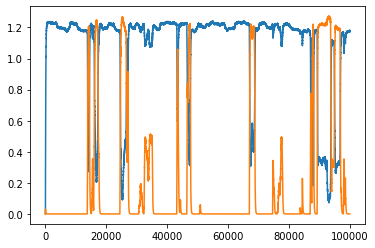

In [13]:
plt.figure()
plt.plot(sim.data[region_mem_p])

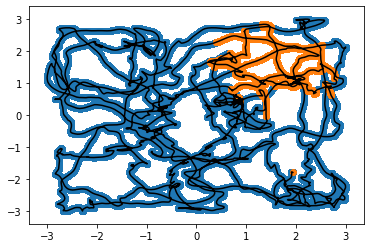

In [14]:
mem_reg_guess = np.argmax(sim.data[region_mem_p],axis=1)
sim_path = np.repeat(path, int(dt/sim.dt),axis=0)#[:int(50/sim.dt),:]
plt.figure()
plt.plot(path[:,0],path[:,1],'-k')
plt.scatter(sim_path[mem_reg_guess==0,0],sim_path[mem_reg_guess==0,1])
plt.scatter(sim_path[mem_reg_guess==1,0],sim_path[mem_reg_guess==1,1])

In [15]:
r1_pt = np.argmin(np.sum((path - np.array([-2,-2]))**2, axis=1))
r2_pt = np.argmin(np.sum((path - np.array([2,2]))**2, axis=1))

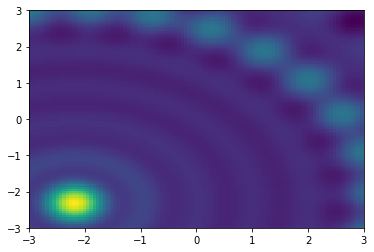

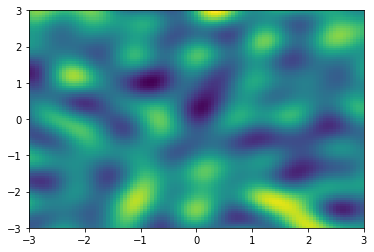

In [16]:
ssp_space.similarity_plot(ssp_space.encode(np.atleast_2d(path[r1_pt,:])))
ssp_space.similarity_plot(sim.data[ens_p][int(dt/sim.dt)*r1_pt,:])

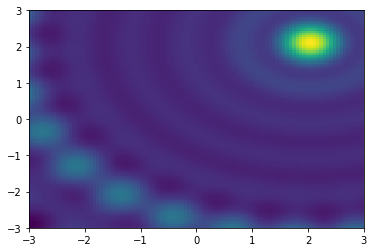

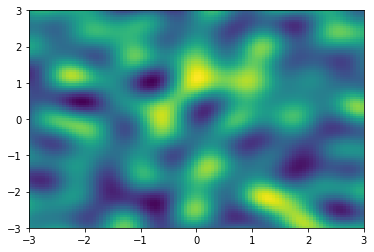

In [17]:
ssp_space.similarity_plot(ssp_space.encode(np.atleast_2d(path[r2_pt,:])))
ssp_space.similarity_plot(sim.data[ens_p][int(dt/sim.dt)*r2_pt,:])

In [18]:
def _get_to_SSP_mat(D):
    W = np.fft.ifft(np.eye(D))
    W1 = W.real @ np.fft.ifftshift(np.eye(D),axes=0)
    W2 = W.imag @ np.fft.ifftshift(np.eye(D),axes=0)
    shiftmat1 = np.vstack([np.eye(D//2), np.zeros((1,D//2)), np.flip(np.eye(D//2), axis=0)])
    shiftmat2 = np.vstack([np.eye(D//2), np.zeros((1,D//2)), -np.flip(np.eye(D//2), axis=0)])
    shiftmat = np.vstack([ np.hstack([shiftmat1, np.zeros(shiftmat2.shape)]),
                          np.hstack([np.zeros(shiftmat2.shape), shiftmat2])])
    shiftmat = np.hstack([shiftmat, np.zeros((shiftmat.shape[0],1))])
    shiftmat[D//2,-1] = 1
    tr = np.hstack([W1, -W2]) @ shiftmat 
    return tr

def _get_from_SSP_mat(D):
    W = np.fft.fft(np.eye(D))
    W1 = np.fft.fftshift(np.eye(D),axes=0) @ W.real 
    W2 = np.fft.fftshift(np.eye(D),axes=0) @ W.imag 
    shiftmat1 = np.hstack([np.eye(D//2), np.zeros((D//2, 2*(D//2) + D//2 + 2))])
    shiftmat2 = np.hstack([np.zeros((D//2, 2*(D//2) + 1)), np.eye(D//2), np.zeros((D//2, D//2 + 1))])
    shiftmat = np.vstack([ shiftmat1,shiftmat2])
    tr = shiftmat @ np.vstack([W1, W2]) 
    return tr



In [19]:
idxs = np.arange(ssp_space.num_grids)
scaleidxs = np.mod(idxs,n_rotates)
scaleidxs[scaleidxs==0] = n_rotates
scaleidxs[idxs==0]=0

r1_subens = np.where(scaleidxs < break_idx)[0]
r2_subens = np.where(scaleidxs >= break_idx)[0]

to_SSP = _get_to_SSP_mat(d)
from_SSP = _get_from_SSP_mat(d)

n_neurons = 200
model = nengo.Network()
with model:
    in_node = nengo.Node(lambda t: ssp_space.encode(np.atleast_2d(path[int(t/dt)-1,:])).reshape(-1))
    
    ens = nengo.networks.EnsembleArray(n_neurons, ssp_space.num_grids + 1, ssp_space.grid_basis_dim*2 )
    nengo.Connection(in_node, ens.input[:-6], transform=from_SSP, synapse=None)
    zerofreq = nengo.Node([1,0,0,0,0,0])
    nengo.Connection(zerofreq, ens.ea_ensembles[-1])
    
    ssp = nengo.Node(size_in=d)
    nengo.Connection(ens.output[:-5], ssp, transform=to_SSP) 
    
    region_mem = nengo.networks.AssociativeMemory(S_regions, output_vectors=np.eye(2),
                                                  n_neurons=50, threshold=0.3)
    
    def one_hot(t,x):
        r = np.zeros(len(x))
        r[np.argmax(x)]=1
        return r
    
    region_select = nengo.Node(one_hot, size_in=2)
    nengo.Connection(region_mem.output, region_select, synapse=0.1)
    
    nengo.Connection(in_node, region_mem.input, synapse=None)
    
    for i in r1_subens:
        nengo.Connection(region_select[1],
                     ens.ea_ensembles[i].neurons, transform=[[-10]] * n_neurons)
    for i in r2_subens:   
        nengo.Connection(region_select[0],
                     ens.ea_ensembles[i].neurons, transform=[[-10]] * n_neurons) 
    
    ssp_p = nengo.Probe(ssp, synapse=0.1)
    fssp_p = nengo.Probe(ens.output, synapse=0.1)
    
    fssp1_p = nengo.Probe(ens.ea_ensembles[r1_subens[0]], synapse=0.1)
    fssp2_p = nengo.Probe(ens.ea_ensembles[r2_subens[0]], synapse=0.1)
    
    region_mem_p = nengo.Probe(region_select, synapse=None)
    
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

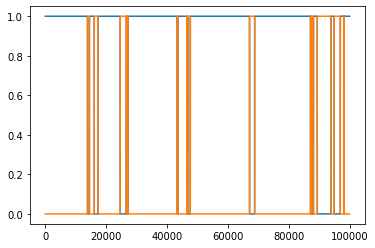

In [20]:
plt.figure()
plt.plot(sim.data[region_mem_p])

In [21]:
r1_pt = np.argmin(np.sum((path - np.array([-2,-2]))**2, axis=1))
r2_pt = np.argmin(np.sum((path - np.array([2,2]))**2, axis=1))

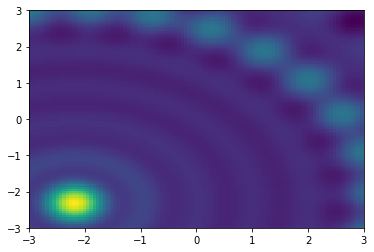

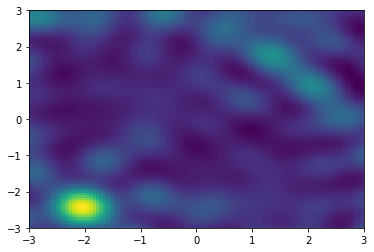

In [22]:
ssp_space.similarity_plot(ssp_space.encode(np.atleast_2d(path[r1_pt,:])))
ssp_space.similarity_plot(sim.data[ssp_p][int(dt/sim.dt)*r1_pt,:])

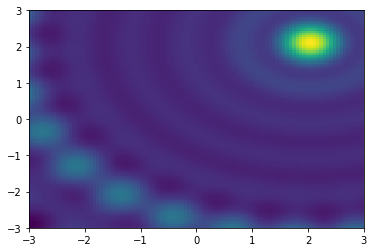

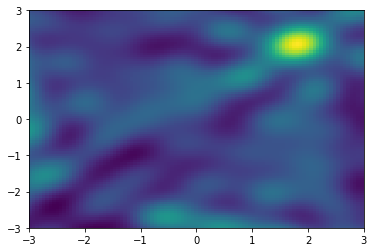

In [23]:
ssp_space.similarity_plot(ssp_space.encode(np.atleast_2d(path[r2_pt,:])))
ssp_space.similarity_plot(sim.data[ssp_p][int(dt/sim.dt)*r2_pt,:])

In [26]:
def region_mask_ssp(ssp):
    fssp = np.fft.fft(ssp,axis=1)
    # weights = softmax(S_regions @ ssp.T)
    probs = softmax(S_regions @ ssp.T)
    maxprobs = np.argmax(probs,axis=0)
    weights = np.zeros((S_regions.shape[0],ssp.shape[0])) 
    weights[(maxprobs,np.arange(ssp.shape[0]))] = 1
    weighted_masks =  weights.T @ masks
    #np.sum(weights * masks, axis=0)
    return np.fft.ifft(weighted_masks*fssp,axis=1).real

n_neurons=2000
with model:
    in_node = nengo.Node(lambda t: ssp_space.encode(np.atleast_2d(path[int(t/dt)-1,:])).reshape(-1))
    
    ens = nengo.Ensemble(n_neurons, dimensions=d, radius = 1)
    
    ssp_p = nengo.Probe(ens, synapse=0.1)
    
    
sim = nengo.Simulator(model)
sim.run(3)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

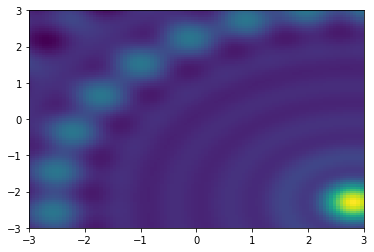

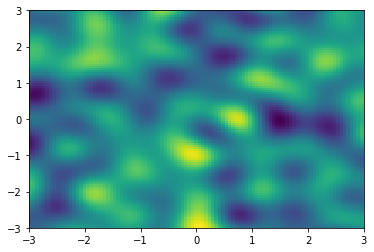

In [28]:
ssp_space.similarity_plot(ssp_space.encode(np.atleast_2d(path[100,:])))
ssp_space.similarity_plot(sim.data[ssp_p][int(dt/sim.dt)*100,:])

In [32]:
def get_region_mask(ssp):
    fssp = np.fft.fft(ssp,axis=1)
    # weights = softmax(S_regions @ ssp.T)
    probs = softmax(S_regions @ ssp.T)
    maxprobs = np.argmax(probs,axis=0)
    weights = np.zeros((S_regions.shape[0],ssp.shape[0])) 
    weights[(maxprobs,np.arange(ssp.shape[0]))] = 1
    weighted_masks =  weights.T @ masks
    #np.sum(weights * masks, axis=0)
    return weighted_masks.reshape(-1)

with model:
    in_node = nengo.Node(lambda t: ssp_space.encode(np.atleast_2d(path[int(t/dt)-1,:])).reshape(-1))
    
    ens = nengo.networks.EnsembleArray(200, ssp_space.num_grids + 1, ssp_space.grid_basis_dim*2 )
    nengo.Connection(in_node, ens.input[:-6], transform=from_SSP, synapse=None)
    ssp = nengo.Node(size_in=d)
    nengo.Connection(ens.output[:-5], ssp, transform=to_SSP)
    
    mask_node = nengo.Node(lambda t: get_region_mask(ssp_space.encode(np.atleast_2d(path[int(t/dt)-1,:]))))
    
    binding_net = nengo.networks.CircularConvolution(100, d)
    nengo.Connection(ssp, binding_net.input_a, synapse=0.05)
    nengo.Connection(mask_node, binding_net.input_b, synapse=0.05)
    
    ssp_p = nengo.Probe(ssp, synapse=0.1)
    mask_p = nengo.Probe(mask_node, synapse=None)
    nonstat_ssp_p = nengo.Probe(binding_net.output, synapse=0.1)
    
    
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.